<a href="https://colab.research.google.com/github/SravanthiS7/fmml-lab-1/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-12 12:35:58--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.225.4.25, 13.225.4.31, 13.225.4.109, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.225.4.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   227MB/s    in 0.2s    

2024-05-12 12:35:58 (227 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


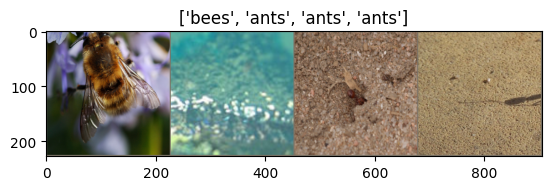

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.7629 Acc: 0.6393

Epoch 1/4
----------
Loss: 0.6227 Acc: 0.7705

Epoch 2/4
----------
Loss: 0.5397 Acc: 0.7869

Epoch 3/4
----------
Loss: 0.5200 Acc: 0.8033

Epoch 4/4
----------
Loss: 0.6108 Acc: 0.7828



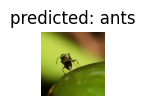

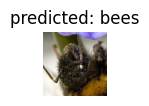

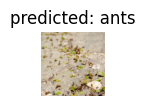

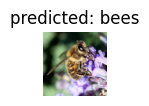

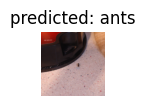

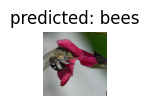

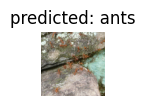

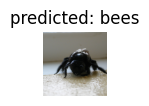

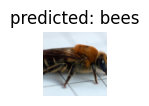

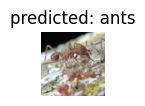

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


**1. Answer**:

Data augmentation techniques like resizing, cropping, rotating, flipping, and adding noise are crucial in training machine learning models, especially for tasks like image classification, object detection, and segmentation. Here's why they're significant:
1.**Increased Variation:** By applying augmentations, you artificially increase the size of your training dataset by generating new samples from the existing ones. This helps in introducing more variability into the training data, which can prevent overfitting and improve generalization performance. Models trained on augmented data tend to perform better on unseen or real-world data.
2.**Robustness to Variations:** Real-world data often comes with variations such as changes in scale, orientation, illumination, and noise. Augmentations help the model become robust to these variations by exposing it to different conditions during training. For example, if your task is to classify images of cats, augmentations like random rotations and flips can help the model learn to recognize cats from various angles.
3.**Regularization:** Augmentations act as a form of regularization by adding noise or perturbations to the training data. This can help prevent the model from memorizing the training examples too closely and encourage it to learn more generalizable features.
4.**Data Balance:** Augmentations can also help balance class distributions in the training data. For imbalanced datasets, where certain classes have significantly fewer samples than others, augmenting the minority classes can help alleviate this issue and improve model performance on the underrepresented classes.
**5.Reduced Dependency on Large Datasets:** Augmentations allow you to train effective models even when you have limited training data. Instead of collecting a large number of diverse samples, you can generate additional training examples through augmentations, thereby reducing the need for extensive data collection efforts.

**2.Answer:**
If you don't use a pre-trained ResNet model and instead train it from scratch on your dataset, the performance may vary depending on factors such as the size and diversity of your dataset, the complexity of the task, and the resources available for training.

Training a deep neural network like ResNet from scratch typically requires a large amount of labeled data and significant computational resources. Without pre-training, the model starts with random weights, and it needs to learn meaningful representations of the data through the training process.

The performance you can achieve without pre-training might be lower compared to using a pre-trained model, especially if your dataset is relatively small or if it doesn't contain a wide variety of examples to learn from. Additionally, training from scratch might require more epochs to converge to a good solution, which can increase training time and resource requirements.

However, in some cases, training from scratch might be necessary or preferable, especially if your dataset is domain-specific and differs significantly from the pre-training data. It allows the model to learn representations tailored specifically to your task or dataset.

To evaluate the performance of a ResNet model trained from scratch, you would typically monitor metrics such as accuracy, precision, recall, F1-score, or any other relevant metrics for your specific task. You would compare these metrics against those achieved by a pre-trained model or against a baseline to assess the effectiveness of training from scratch.


**3rd Answer:**

**1.Transfer Learning:** Pre-trained models, especially those trained on large and diverse datasets like ImageNet, learn general features that are applicable to a wide range of tasks and datasets. Even though the pre-training dataset might be different from the ants vs. bees dataset, the learned features can still be beneficial for tasks like image classification.

**2.Feature Extraction:** In transfer learning, you can use pre-trained models as feature extractors. By freezing the weights of the pre-trained layers and adding new fully connected layers on top, you can train only the new layers on your dataset. This allows you to leverage the pre-trained model's learned representations while adapting it to your specific task.

**3.Fine-tuning:** Alternatively, you can fine-tune the pre-trained model by unfreezing some of its layers and continuing training on your dataset with a smaller learning rate. This allows the model to adjust its weights not only to the new task but also to the specifics of your dataset.

**4.Performance Variation:** The performance improvement achieved by using a pre-trained model depends on factors such as the similarity between the pre-training and target datasets, the size of the target dataset, and the complexity of the task. In some cases, using a pre-trained model might lead to significant performance gains, while in others, the improvement might be more modest.

 **5.Domain-Specific Features:**If the ants vs. bees dataset contains features or patterns that are not well represented in the pre-training dataset, fine-tuning or training from scratch might be more beneficial. In such cases, the pre-trained model's features may not be sufficiently adapted to the target task, and training from scratch or fine-tuning might be necessary to learn task-specific features.